In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix

In [3]:
def read_data(pkl_path, label_encoder=None):
    features_list = []
    labels_list = []

    with open(pkl_path, 'rb') as file:
        raw_data = pickle.load(file)

    for label, _, coordinates in raw_data:
        flat_coordinates = [coord for pair in coordinates for coord in pair]
        reshaped_coordinates = np.array(flat_coordinates).reshape(29, 80)
        feature_tensor = torch.tensor(reshaped_coordinates, dtype=torch.float32)
        features_list.append(feature_tensor)
        labels_list.append(label)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        labels_encoded = label_encoder.fit_transform(labels_list)
    else:
        labels_encoded = label_encoder.transform(labels_list)

    return features_list, labels_encoded, label_encoder

In [4]:
class LipPointsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [5]:
def collate_fn(batch):
    features, labels = zip(*batch)
    features = [torch.as_tensor(f, dtype=torch.float32) for f in features]
    padded_features = pad_sequence(features, batch_first=True)
    return padded_features, torch.tensor(labels)

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=55):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        div_term = div_term.unsqueeze(0)  # Adjusting shape for broadcasting

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # Add batch dimension [1, max_len, d_model]

    def forward(self, x):
        # Expand PE to match the batch size in x
        x = x + self.pe[:, :x.size(1), :].expand_as(x)
        return self.dropout(x)


class LipReadingTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, num_classes, max_seq_len=55):
        super(LipReadingTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        transformed = self.transformer_encoder(src)
        logits = self.fc_out(transformed[:, -1, :])
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        return probabilities

In [7]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch_features, batch_labels in dataloader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return average_loss, accuracy

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predicted_labels = []
    all_true_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)

            # Collect all labels and predictions for confusion matrix
            all_predicted_labels.extend(predicted_labels.tolist())
            all_true_labels.extend(batch_labels.tolist())

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    return average_loss, accuracy, conf_matrix

In [9]:
def plot_metrics(train_losses, val_losses, train_accuracies=None, val_accuracies=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if train_accuracies and val_accuracies:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, 'b-', label='Training accuracy')
        plt.plot(epochs, val_accuracies, 'r-', label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epochs_no_improve = 0

        # if self.verbose and self.early_stop:
            # print(f"Early stopping triggered after {self.patience} epochs without improvement")

In [11]:
def plot_conf_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
def main(params, grid_search=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    pkl_path = '/content/drive/MyDrive/lipreader_data'
    train_pkl_path = os.path.join(pkl_path, 'train.pkl')
    val_pkl_path = os.path.join(pkl_path, 'val.pkl')
    test_pkl_path = os.path.join(pkl_path, 'test.pkl')

    _, _, label_encoder = read_data(train_pkl_path)
    train_features_list, train_labels_encoded, _ = read_data(train_pkl_path, label_encoder)
    val_features_list, val_labels_encoded, _ = read_data(val_pkl_path, label_encoder)
    test_features_list, test_labels_encoded, _ = read_data(test_pkl_path, label_encoder)
    if not grid_search:
        print ('Finished reading data!')

    train_dataset = LipPointsDataset(train_features_list, train_labels_encoded)
    val_dataset = LipPointsDataset(val_features_list, val_labels_encoded)
    test_dataset = LipPointsDataset(test_features_list, test_labels_encoded)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=collate_fn)
    if not grid_search:
        print ('Finished loading data!')

    input_dim = 80
    d_model = params['d_model']
    nhead = params['nhead']
    num_encoder_layers = params['num_encoder_layers']
    num_classes = len(label_encoder.classes_)

    model = LipReadingTransformer(input_dim, d_model, nhead, num_encoder_layers, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    early_stopping = EarlyStopping(patience=100, verbose=True)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(params['epoch']):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, _ = evaluate(model, val_loader, criterion, device)

        # Collect metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if not grid_search:
          print(f'Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}')

        # Call early stopping
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
            # break

    # Evaluate on test set after fine-tuning
    test_loss, test_accuracy, conf_matrix = evaluate(model, test_loader, criterion, device)

    print(f'Total Training epoch: {epoch}, Test Accuracy: {test_accuracy:.4f}')

    # Save model and Plot
    if not grid_search:
      plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
      plot_conf_matrix(conf_matrix, label_encoder.classes_)
      torch.save(model.state_dict(), 'lip_reading_model.pth')

Finished reading data!
Finished loading data!
Epoch 1: Train Loss = 2.3037, Train Accuracy = 0.0998, Validation Loss = 2.3031, Validation Accuracy = 0.1006
Epoch 2: Train Loss = 2.3030, Train Accuracy = 0.0962, Validation Loss = 2.3029, Validation Accuracy = 0.1027
Epoch 3: Train Loss = 2.3024, Train Accuracy = 0.1020, Validation Loss = 2.3024, Validation Accuracy = 0.1129
Epoch 4: Train Loss = 2.3023, Train Accuracy = 0.1056, Validation Loss = 2.3022, Validation Accuracy = 0.1294
Epoch 5: Train Loss = 2.3024, Train Accuracy = 0.1056, Validation Loss = 2.3025, Validation Accuracy = 0.1088
Epoch 6: Train Loss = 2.3021, Train Accuracy = 0.1073, Validation Loss = 2.3021, Validation Accuracy = 0.1006
Epoch 7: Train Loss = 2.3020, Train Accuracy = 0.1139, Validation Loss = 2.3022, Validation Accuracy = 0.1068
Epoch 8: Train Loss = 2.3008, Train Accuracy = 0.1132, Validation Loss = 2.3014, Validation Accuracy = 0.1047
Epoch 9: Train Loss = 2.2997, Train Accuracy = 0.1131, Validation Loss = 2

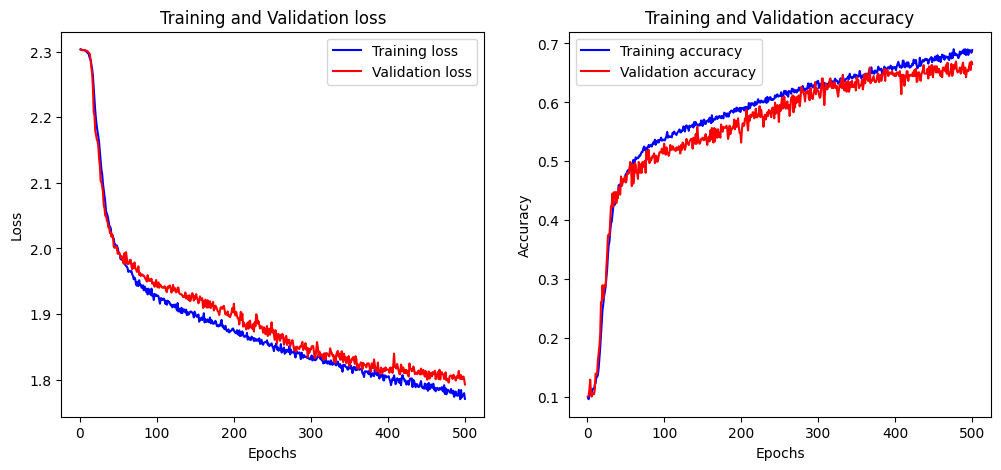

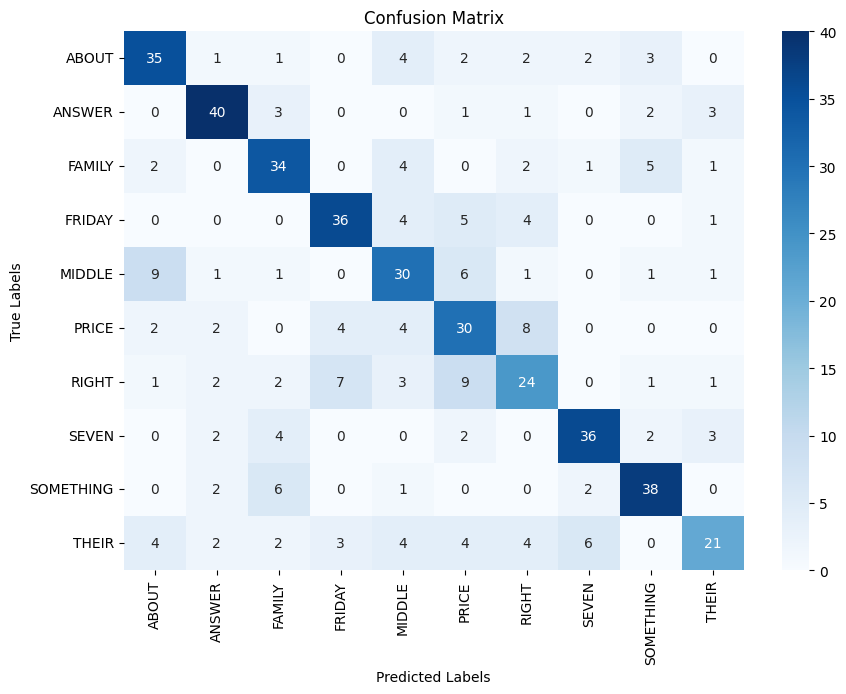

In [17]:
params = {
    'batch_size': 512,
    'd_model': 64,
    'nhead': 8,
    'num_encoder_layers': 2,
    'learning_rate': 0.0001,
    'epoch': 500,
}
main(params)

In [14]:
# grid search
batch_size = [128, 512, 1024, 2048]
d_model = [64, 128, 256, 512]
nhead = [2, 4, 8]
num_encoder_layers = [1, 2, 3]
learning_rate = [0.001, 0.0005, 0.0001]
epoch = [500]


for bs in batch_size:
  for d in d_model:
    for nh in nhead:
      for nl in num_encoder_layers:
        for lr in learning_rate:
          for ep in epoch:
            print (f'batch_size: {bs}, d_model: {d}, nhead: {nh}, num_encoder_layers: {nl}, learning_rate: {lr}, eposh: {ep}')
            params = {
              'batch_size': bs,
              'd_model': d,
              'nhead': nh,
              'num_encoder_layers': nl,
              'learning_rate': lr,
              'epoch': ep,
            }
            main(params, grid_search=True)

batch_size: 128, d_model: 64, nhead: 2, num_encoder_layers: 1, learning_rate: 0.001, eposh: 500
Total Training epoch: 98, Test Accuracy: 0.5795
batch_size: 128, d_model: 64, nhead: 2, num_encoder_layers: 1, learning_rate: 0.0005, eposh: 500
Total Training epoch: 119, Test Accuracy: 0.5553
batch_size: 128, d_model: 64, nhead: 2, num_encoder_layers: 1, learning_rate: 0.0001, eposh: 500
Total Training epoch: 193, Test Accuracy: 0.5573
batch_size: 128, d_model: 64, nhead: 2, num_encoder_layers: 2, learning_rate: 0.001, eposh: 500
Total Training epoch: 230, Test Accuracy: 0.5936
batch_size: 128, d_model: 64, nhead: 2, num_encoder_layers: 2, learning_rate: 0.0005, eposh: 500
Total Training epoch: 186, Test Accuracy: 0.6237
batch_size: 128, d_model: 64, nhead: 2, num_encoder_layers: 2, learning_rate: 0.0001, eposh: 500
Total Training epoch: 185, Test Accuracy: 0.6016
batch_size: 128, d_model: 64, nhead: 2, num_encoder_layers: 3, learning_rate: 0.001, eposh: 500
Total Training epoch: 29, Test 

KeyboardInterrupt: 

In [ ]:
params = {
  'batch_size': bs,
  'd_model': d,
  'nhead': nh,
  'num_encoder_layers': nl,
  'learning_rate': lr,
  'epoch': ep,
}
main(params, grid_search=True)